In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

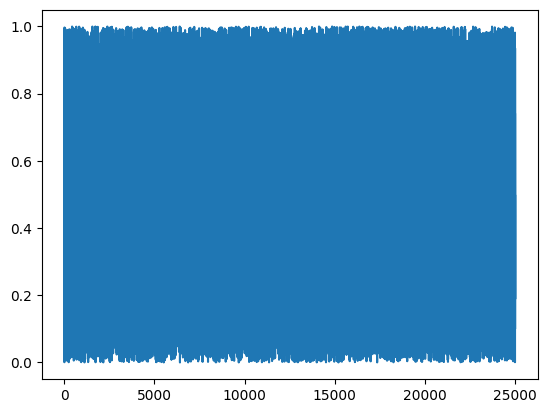

In [22]:
n = 50
p = 500
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
#  we let r=25
r = 30
y = np.zeros(n) #initialising y array
sigmay = 0.1
for i in range(n):
    yTemp = X[i][0:r].sum() + np.random.normal(0, sigmay) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [23]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta[i] = 1                                
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                w1 = 1 - w2
                U = np.random.uniform(0,1)
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])

    # print("Number of samples is" % str(len(samples)))
    return np.asarray(samples)


# trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

In [24]:
@jit
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

@jit
def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

@jit
def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

@jit
def ssp(theta, gamma, X, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [25]:
def metroHastings(sigma1, sigma2, sigmay, sigma_theta, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    gamma = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                     #--- initialising theta as zero vectors
    # theta_0 = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1))
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(theta_0.T[0], np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, X, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, X, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR
        # print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas


# samples = metroHastings(sigma1 = 1, sigma2 = 0.01, sigmay = 0.01, sigma_theta = 1, X = X, y = y, niter = 50000)
# samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, sigma_theta = 1, X = X, y = y, niter = 100000)

In [26]:
traceSGS = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, X = X, y = y, niter = 50000)

sampleSGS = tf.convert_to_tensor(traceSGS, dtype=tf.float32)
plt.plot(sampleSGS)
meanSGS, varianceSgs = tf.nn.moments(sampleSGS, axes=0)
print(meanSGS)

C:\Users\Johnny Lee\AppData\Local\Temp\ipykernel_2064\2823989320.py:19: RuntimeWarning: overflow encountered in exp
  mhr = np.exp(log_joint_candidate - log_joint_old)                   #--- To lessen change of underflows/overflows with MHR


Acceptance Rate is 0.06914, with total number of acceptance of 3457
tf.Tensor(
[ 0.9914345   0.9262978   0.9924702   0.9987347   0.999015    0.94146705
  0.946384    0.96423674  0.98923296  0.96475524  0.9726782   0.9587563
  0.9690869   0.9722211   1.0002501   0.9805198   0.9639443   0.9219828
  0.9861011   0.98425025  1.019987    0.97203904  0.90169376  0.97175896
  0.9774208   0.9484654   0.9519566   1.0007751   0.9928351   0.9709607
  0.01218854  0.02133288  0.08124796  0.03876454  0.03508805  0.01059967
  0.06872592 -0.02303757  0.01820069  0.04159087  0.0233095   0.0452331
  0.0194865   0.01645863 -0.01143221  0.03581783  0.04633516  0.0036582
  0.01721724  0.06438959], shape=(50,), dtype=float32)


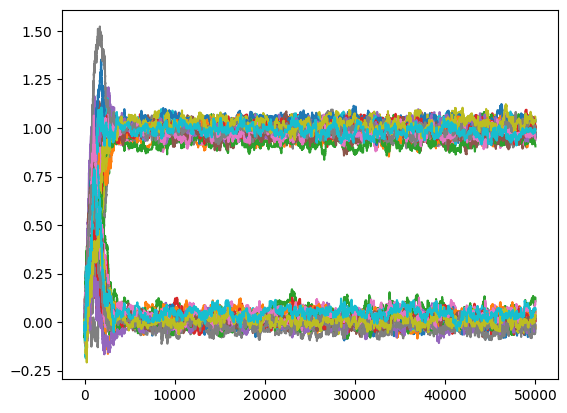

In [ ]:
traceMh = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = sigmay, sigma_theta = 0.0001, X = X, y = y, niter = 50000)
sampleMh = tf.convert_to_tensor(traceMh, dtype = tf.float32)
plt.plot(sampleMh)
# mean-mh, variance = tf.nn.moments(trace, axes=0)
meanMh = tf.math.reduce_mean(sampleMh, axis=0)
print(meanMh)